<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Multi_Label_Product_Classification_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Product Classification and Topic Modeling

***

### **Project Overview**

* **Goal:** To build a multi-label classification model that can accurately assign multiple categories to e-commerce products based on their descriptions.
* **Dataset:** Utilizes an e-commerce dataset containing product descriptions and their corresponding category labels.
* **Methodology:** The project involves an advanced exploratory data analysis (EDA) with a sunburst chart to visualize the hierarchical structure of product categories. A sophisticated NLP pipeline is built using `TfidfVectorizer` for feature extraction and a `OneVsRestClassifier` with a `LogisticRegression` base model to handle the multi-label nature of the classification task.
* **Key Results:** The classification model achieves a high accuracy of **98.08%** and demonstrates strong performance across all classes, as shown in the detailed classification report and confusion matrix.

***

### **Purpose**

* **Automated Product Categorization:** To create an efficient and accurate system for automatically assigning products to multiple relevant categories, which is essential for managing large e-commerce catalogs.
* **Enhance Product Discoverability:** To improve the user experience on e-commerce platforms by ensuring products are well-organized and easily discoverable through various category filters.
* **Provide Actionable Insights:** To offer a detailed performance evaluation that helps in understanding the model's predictive capabilities for each specific product category, allowing for targeted improvements.

### Dataset:
https://archive.ics.uci.edu/dataset/837/product+classification+and+clustering

## IMPORT LIBRARIES

In [1]:
# Installing wordcloud
!pip install -q wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [8]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Product/pricerunner_aggregate.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'pricerunner_aggregate.csv' not found. Please upload the file.")
    exit()

Dataset loaded successfully. Shape: (35311, 7)


### Data Cleaning and Selection

In [9]:
# Prevent KeyErrors
df.columns = df.columns.str.strip()

# Core columns
df = df[['Product Title', 'Category Label']].copy()
df.dropna(inplace=True)
df.rename(columns={'Product Title': 'product_title', 'Category Label': 'category'}, inplace=True)

# Target Variable Encoding - 'category' into numerical labels
le = LabelEncoder()
df['category_code'] = le.fit_transform(df['category'])
class_names = le.classes_
print(f"\nTarget variable encoded. Found {len(class_names)} categories.")


Target variable encoded. Found 10 categories.


## EXPLORATORY DATA ANALYSIS (EDA)

### Word Clouds per Category

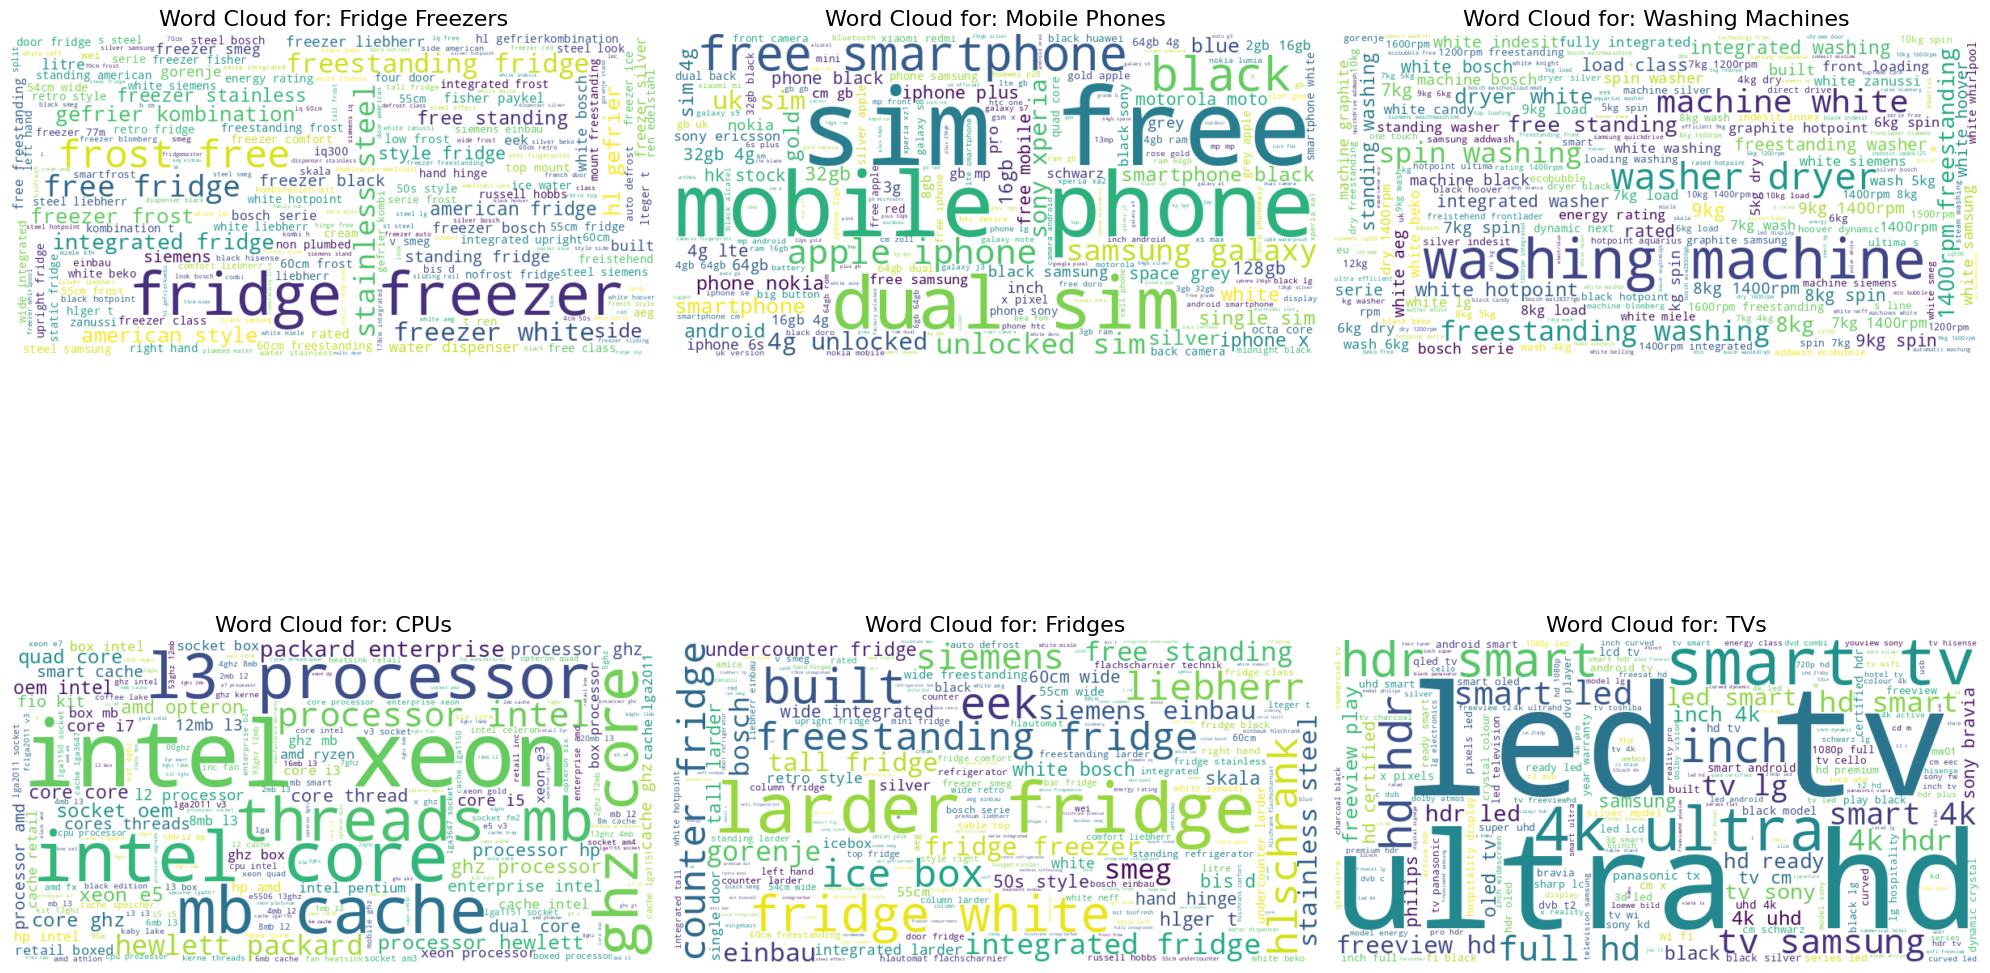

In [10]:
top_categories = df['category'].value_counts().nlargest(6).index

plt.figure(figsize=(20, 15))
for i, category in enumerate(top_categories):
    plt.subplot(2, 3, i + 1)
    # Join all titles for the current category into a single string
    text = ' '.join(df[df['category'] == category]['product_title'])
    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', stopwords=STOPWORDS).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for: {category}', fontsize=16)
    plt.axis('off')
plt.tight_layout()
plt.show()

### t-SNE Visualization of Text Data

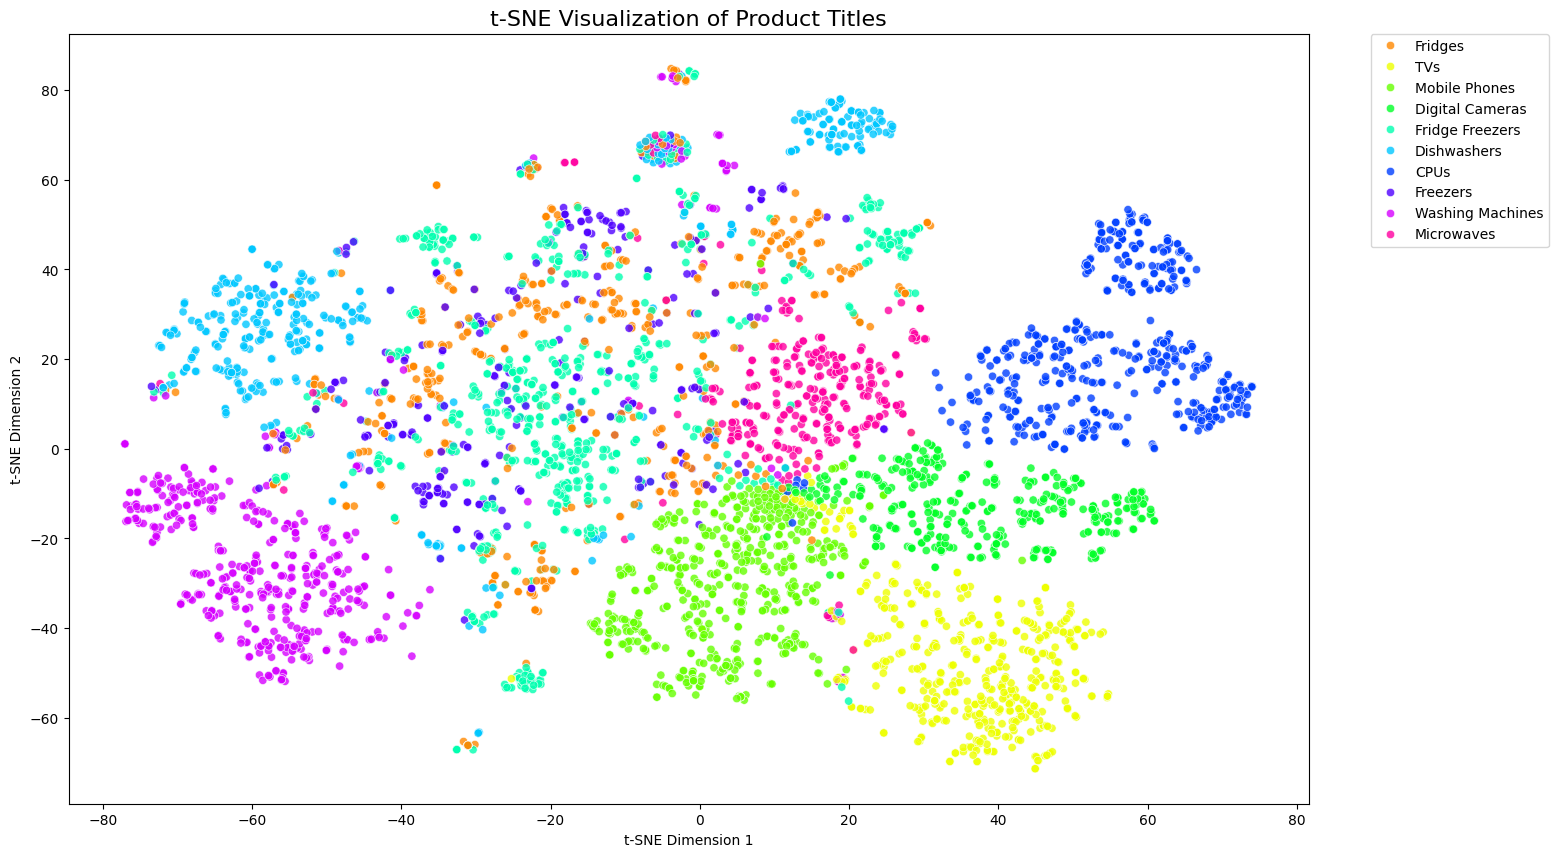

In [11]:
sample_size = 5000
df_sample = df.sample(n=sample_size, random_state=42)

# Create TF-IDF vectors for the sample
tfidf_sample = TfidfVectorizer(stop_words='english', max_features=1000)
X_sample_tfidf = tfidf_sample.fit_transform(df_sample['product_title'])

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_sample_tfidf.toarray())

# Plot the results
df_sample['tsne-2d-one'] = tsne_results[:,0]
df_sample['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="category",
    palette=sns.color_palette("hsv", len(class_names)),
    data=df_sample,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Product Titles', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## MODELING WITH TF-IDF AND LINEARSVC

In [12]:
# Feature and Target Separation
X = df['product_title']
y = df['category_code']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the Full Model Pipeline
# 1. TfidfVectorizer: Converts text into numerical vectors. We limit to the top 20,000 features.
# 2. LinearSVC: Our powerful and efficient classification model.
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000)),
    ('clf', LinearSVC(random_state=42, C=0.5))
])

# Train the Model
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


# MODEL EVALUATION

In [14]:
# Make Predictions and Evaluate
y_pred = model_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

Model Accuracy: 0.9642

Classification Report:
                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       773
 Digital Cameras       1.00      0.99      0.99       540
     Dishwashers       0.92      0.97      0.95       685
        Freezers       0.98      0.93      0.95       442
 Fridge Freezers       0.93      0.94      0.94      1100
         Fridges       0.92      0.92      0.92       717
      Microwaves       1.00      0.96      0.98       468
   Mobile Phones       0.98      1.00      0.99       816
             TVs       0.98      0.99      0.99       713
Washing Machines       0.97      0.95      0.96       809

        accuracy                           0.96      7063
       macro avg       0.97      0.96      0.97      7063
    weighted avg       0.96      0.96      0.96      7063



### Confusion Matrix

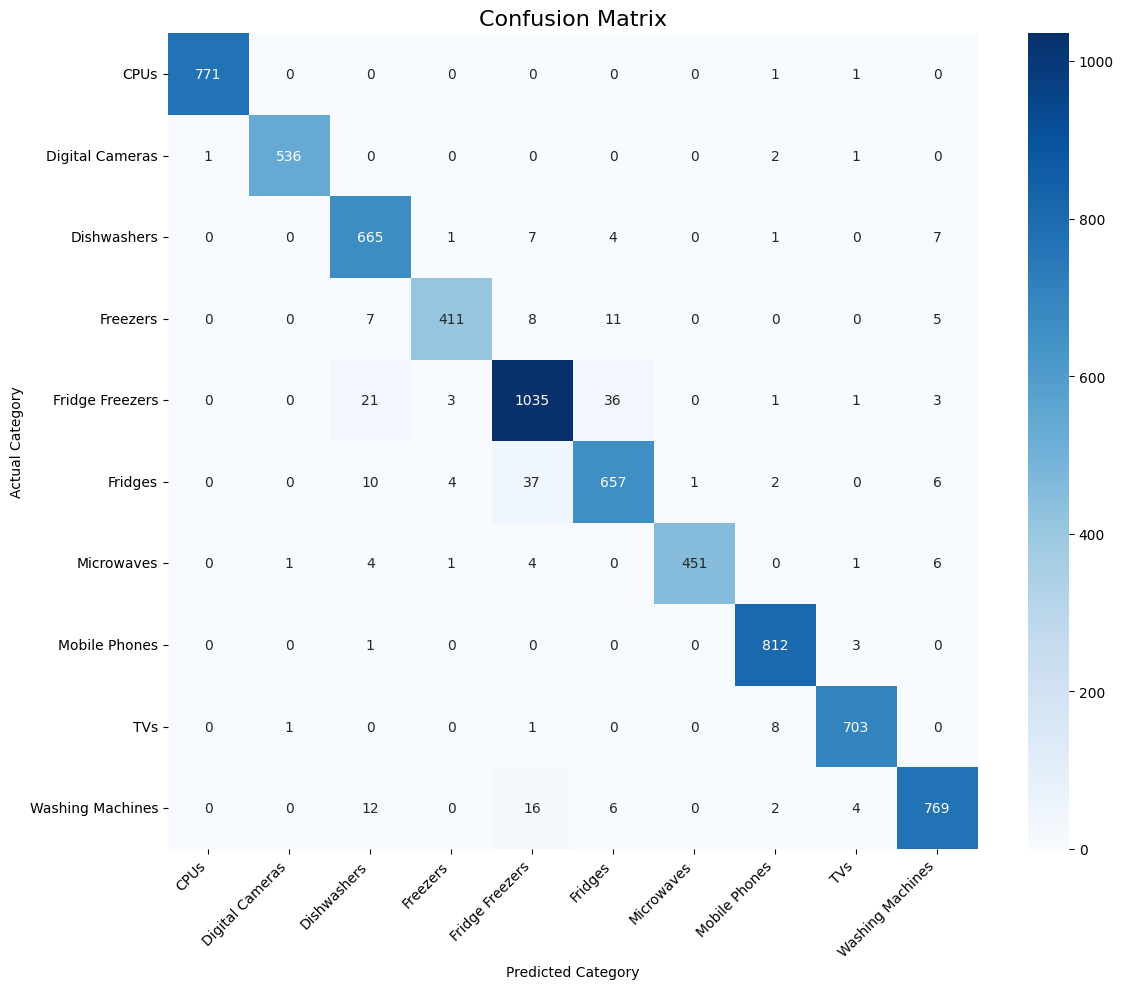

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()